In [1]:
import pickle
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
from tqdm import tqdm
import random
import torch.optim as optim
from sklearn.model_selection import train_test_split
from torch.utils.data import TensorDataset, DataLoader
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score
from scipy.stats import pearsonr
from scipy.stats import spearmanr
from scipy.stats import kendalltau

In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [3]:
# with open('X_uniform-Copy1.pkl','rb') as file:
#     x = pickle.load(file)
# with open('Y_uniform-Copy1.pkl','rb') as file:
#     y = pickle.load(file)
with open('zie_uniform-Copy1.pkl','rb') as file:
    zie = pickle.load(file)

In [23]:
# x,x.shape

(tensor([[ 1.7103,  1.7103,  1.7103,  ..., -6.8445, -6.8445, -6.8445],
         [ 8.5300,  8.5300,  8.5300,  ..., -6.3845, -6.3845, -6.3845],
         [-6.0266, -6.0266, -6.0266,  ..., -7.0155, -7.0155, -7.0155],
         ...,
         [ 6.9653,  6.9653,  6.9653,  ...,  5.1985,  5.1985,  5.1985],
         [-8.4326, -8.4326, -8.4326,  ...,  8.8994,  8.8994,  8.8994],
         [-3.3060, -3.3060, -3.3060,  ..., -8.7325, -8.7325, -8.7325]]),
 torch.Size([2500, 40000]))

In [7]:
# x[:,0]

tensor([ 1.7103,  8.5300, -6.0266,  ...,  6.9653, -8.4326, -3.3060])

In [4]:
zie.shape

(40000, 1)

In [57]:
'''
Function to count number of atoms in  a grid with number of grids as the parameter.

def count_atoms_in_grid(x, y, num_grids):
    # Calculate the grid size
    grid_size = 20 / num_grids

    # Create an empty grid to store the atom counts
    atom_counts = torch.zeros(num_grids, num_grids)

    # Iterate through each atom coordinate
    for i in range(x.shape[0]):
        # Calculate the grid indices for the atom
        grid_x = int((x[i] + 10) // grid_size)
        grid_y = int((y[i] + 10) // grid_size)

        # Increment the atom count in the corresponding grid
        atom_counts[grid_x, grid_y] += 1

    return atom_counts
'''

In [61]:
# x = x.numpy()
# y = y.numpy()

In [107]:
# inp = []
# for i in tqdm(range(40000)):
#     atom_count = count_atoms_in_grid(x[:,i],y[:,i],20)
#     atom_count = atom_count.numpy()
#     inp.append(atom_count)


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 40000/40000 [47:28<00:00, 14.04it/s]


In [108]:
# inp = np.array(inp)

In [110]:
# with open('inp25.pkl', 'wb') as file:
#     pickle.dump(inp,file) 

In [5]:
with open('inp20.pkl','rb') as file:
    inp = pickle.load(file)

In [6]:
inp.shape

(40000, 20, 20)

In [7]:
inp = inp.reshape(40000,1,inp.shape[1],inp.shape[1])

In [8]:
inp_train, inp_val, z_train, z_val = train_test_split(inp, zie, test_size=0.2, random_state=69)
inp_train, inp_test, z_train, z_test = train_test_split(inp_train, z_train, test_size=0.2, random_state=69)

In [9]:
inp_train.shape, inp_val.shape, inp_test.shape

((25600, 1, 20, 20), (8000, 1, 20, 20), (6400, 1, 20, 20))

In [10]:
z_train.shape, z_val.shape, z_test.shape

((25600, 1), (8000, 1), (6400, 1))

In [11]:
learning_rate = 0.0001
batch_size = 32

In [12]:
def getDataLoader(x,y):
    tensor_inp = torch.Tensor(x)
    tensor_z = torch.Tensor(y)
    dataset = TensorDataset(tensor_inp,tensor_z)
    return DataLoader(dataset, batch_size)

In [13]:
def train(
    model,
    dataset,
    optimizer,
    loss,
    length_of_set,
    is_dev=False
):
    total_loss = 0
    y_pred, y_actual = [], []
    model.train()
    for x,y in tqdm(dataset):
        
        if not is_dev: optimizer.zero_grad()

        x = x.to(device)
        y = y.to(device)
        pred = model(x)
        curr_loss = loss(pred, y)
#         loss_batch = 0
#         loss_batch += curr_loss.item()
#         loss_batch = loss_batch*len(y)
        total_loss += curr_loss.item()*len(y)/(length_of_set)

        if not is_dev:
            curr_loss.backward()
            optimizer.step()

#         y_pred += pred
#         y_actual += y
        
        y_pred += pred.flatten().tolist()
        y_actual += y.flatten().tolist()
        
    return total_loss

In [14]:
train_dataloader = getDataLoader(inp_train, z_train)
val_dataloader = getDataLoader(inp_val, z_val)
test_dataloader = getDataLoader(inp_test, z_test)

In [52]:
class CNNModel(nn.Module):
    def __init__(self):
        super(CNNModel, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, stride=1, padding=1)
        self.relu1 = nn.ReLU()
#         self.maxpool1 = nn.MaxPool2d(kernel_size=2, stride=2)
#         self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1)
#         self.relu2 = nn.ReLU()
#         self.maxpool2 = nn.MaxPool2d(kernel_size=2, stride=2)
#         self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=1)
#         self.relu3 = nn.ReLU()
        self.fc1 = nn.Linear(32 * 20 * 20, 1280)
        self.fc2 = nn.Linear(1280, 128)
        self.fc3 = nn.Linear(128, 1)

    def forward(self, x):
        x = self.conv1(x)
        x = self.relu1(x)
#         x = self.maxpool1(x)
#         x = self.conv2(x)
#         x = self.relu2(x)
#         x = self.maxpool2(x)
#         x = self.conv3(x)
#         x = self.relu3(x)
        x = x.view(x.size(0), -1)
        x = self.fc1(x)
        x = self.fc2(x)
        x = self.fc3(x)
        return x

In [53]:
model = CNNModel().to(device)
print(model)
loss = nn.MSELoss().to(device)
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
scheduler = optim.lr_scheduler.LambdaLR(optimizer, lambda epoch: 0.5 ** epoch)

CNNModel(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu1): ReLU()
  (fc1): Linear(in_features=12800, out_features=1280, bias=True)
  (fc2): Linear(in_features=1280, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=1, bias=True)
)


In [54]:
# file = open("uniform1.txt", "a")
# file.write('\n')
num_epochs = 10
losses = []
# file.write(f"Batch Size: {batch_size}, Learning Rate: {learning_rate} \n")
for epoch in range(num_epochs):
    train_loss = train(model, train_dataloader, optimizer, loss, inp_train.shape[0])
    val_loss = train(model, val_dataloader, optimizer, loss, inp_val.shape[0], True)
    print(f'Epoch: {epoch+1}/{num_epochs} train loss: {train_loss} val_loss: {val_loss}')
#     file.write(f'Epoch: {epoch+1}/{num_epochs} train loss: {train_loss} val_loss: {val_loss} \n')
    losses.append(val_loss)
    scheduler.step()
# file.close()

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 250/250 [00:00<00:00, 490.12it/s]


Epoch: 1/10 train loss: 1.8890344615423247 val_loss: 0.0020721534155309193


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 250/250 [00:00<00:00, 506.72it/s]


Epoch: 2/10 train loss: 0.0017948140390217301 val_loss: 0.001597289932193234


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 250/250 [00:00<00:00, 497.01it/s]


Epoch: 3/10 train loss: 0.0015369626795290977 val_loss: 0.0014742843687999996


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 250/250 [00:00<00:00, 464.90it/s]


Epoch: 4/10 train loss: 0.0014355440431972964 val_loss: 0.0013576846565119926


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 250/250 [00:00<00:00, 486.47it/s]


Epoch: 5/10 train loss: 0.0013772900622643662 val_loss: 0.001313707936089486


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 250/250 [00:00<00:00, 477.66it/s]


Epoch: 6/10 train loss: 0.0013423967573180564 val_loss: 0.001332229440566152


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 250/250 [00:00<00:00, 500.39it/s]


Epoch: 7/10 train loss: 0.0013158535250477152 val_loss: 0.0012809940874576563


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 250/250 [00:00<00:00, 485.05it/s]


Epoch: 8/10 train loss: 0.0012954097769397768 val_loss: 0.0012620871190447366


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 250/250 [00:00<00:00, 498.89it/s]


Epoch: 9/10 train loss: 0.0012818090404471162 val_loss: 0.0012590063971001653


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 250/250 [00:00<00:00, 483.95it/s]

Epoch: 10/10 train loss: 0.0012724236313806621 val_loss: 0.0012567376818042246


Text(0, 0.5, 'MSE Loss')

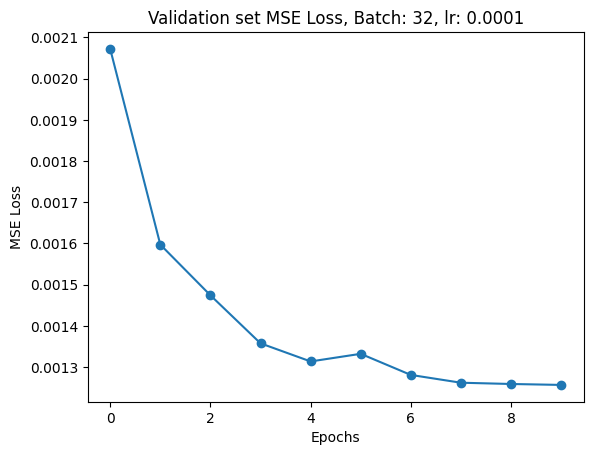

In [55]:
plt.plot(losses, marker='o')
plt.title(f"Validation set MSE Loss, Batch: {batch_size}, lr: {learning_rate}")
plt.xlabel('Epochs')
plt.ylabel('MSE Loss')

In [56]:
test_loss = train(model, test_dataloader, optimizer, loss, inp_test.shape[0], True)
print('test loss:',test_loss)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 482.39it/s]

test loss: 0.0012490261587663556


In [57]:
for inpu, zie in test_dataloader:
    outputs = model(inpu.to(device))
    for i in range(32):
        print(outputs[i],zie[i])
    break

tensor([0.7802], device='cuda:0', grad_fn=<SelectBackward0>) tensor([0.7603])
tensor([0.6641], device='cuda:0', grad_fn=<SelectBackward0>) tensor([0.6802])
tensor([0.0576], device='cuda:0', grad_fn=<SelectBackward0>) tensor([0.0074])
tensor([0.0578], device='cuda:0', grad_fn=<SelectBackward0>) tensor([0.0178])
tensor([0.6442], device='cuda:0', grad_fn=<SelectBackward0>) tensor([0.6747])
tensor([0.5598], device='cuda:0', grad_fn=<SelectBackward0>) tensor([0.5848])
tensor([0.1470], device='cuda:0', grad_fn=<SelectBackward0>) tensor([0.1320])
tensor([0.3483], device='cuda:0', grad_fn=<SelectBackward0>) tensor([0.3415])
tensor([0.2891], device='cuda:0', grad_fn=<SelectBackward0>) tensor([0.3332])
tensor([0.2807], device='cuda:0', grad_fn=<SelectBackward0>) tensor([0.3157])
tensor([0.1357], device='cuda:0', grad_fn=<SelectBackward0>) tensor([0.1054])
tensor([0.1251], device='cuda:0', grad_fn=<SelectBackward0>) tensor([0.0851])
tensor([0.0803], device='cuda:0', grad_fn=<SelectBackward0>) ten

In [58]:
out = []
for inpu, zie in test_dataloader:
    outputs = model(inpu.to(device))
    outputs = outputs.cpu().detach()
    outputs = outputs.numpy()
    out.extend(outputs)

Spearman rank correlation coefficient: 0.9890277803723956
ps-value: 0.0
Kendall rank correlation coefficient: 0.9082842662861507
pk-value: 0.0
R2_sqaure: 0.9764700941266492


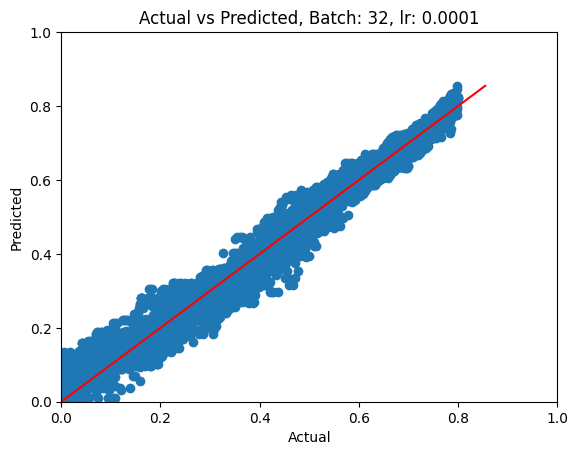

In [59]:
plt.scatter(z_test,out)
plt.xlim([0,1])
plt.ylim([0,1])
plt.title(f"Actual vs Predicted, Batch: {batch_size}, lr: {learning_rate}")
plt.xlabel('Actual')
plt.ylabel('Predicted')

p1 = max(max(out), max(z_test))
p2 = min(min(out), min(z_test))
plt.plot([p1, p2], [p1, p2], 'r-')
# plt.ylim((0.2,0.8))
R_sqaure = r2_score(z_test,out)
# with warnings.catch_warnings():
#     warnings.filterwarnings("ignore", message=".*Nearly constant input.*")
#     p_corr, p_val = pearsonr(z_test, out)
# print(p_corr)
# print(p_val)

s_corr, ps_value = spearmanr(z_test, out)

print("Spearman rank correlation coefficient:", s_corr)
print("ps-value:", ps_value)

k_corr, pk_value = kendalltau(z_test, out)

print("Kendall rank correlation coefficient:", k_corr)
print("pk-value:", pk_value)

print("R2_sqaure:",R_sqaure)
# file = open('uniform1.txt','a')
# file.write(f"test_loss: {test_loss}\n")
# file.write(f"R^2: {R_sqaure}\n")
# file.write(f"Spearman rank correlation coefficient: {s_corr}\n")
# file.write(f"Kendall rank correlation coefficient: {k_corr}\n")
# # file.write(f"p_val: {p_val}")
# file.close()
# plt.savefig(f'uniform1/output{batch_size}lr{learning_rate}.png',bbox_inches='tight')

In [ ]:
'''
grid size 10:
lr = 0.001 loss nan
lr = 0.0001 r2 -ve

grid size 20:
    lr = 0.001 
        b = 32
            Epoch: 10/10 train loss: 0.009364387280656946 val_loss: 0.009326217256486418
            Spearman rank correlation coefficient: 0.9020261207173215
            ps-value: 0.0
            Kendall rank correlation coefficient: 0.7152474594886418
            pk-value: 0.0
            R2_sqaure: 0.8220069712162869
        b = 64
            loss nan

    lr = 0.0001
        b = 32
            Epoch: 10/10 train loss: 0.0012989539166665055 val_loss: 0.0012877737830858682
            test loss: 0.0012928983246092685
            Spearman rank correlation coefficient: 0.9884086770650857
            ps-value: 0.0
            Kendall rank correlation coefficient: 0.9061329292226153
            pk-value: 0.0
            R2_sqaure: 0.9756436039721916
        b = 64
            Epoch: 10/10 train loss: 0.00535023001604713 val_loss: 0.005540662109851834
            test loss: 0.005282533953431995
            Spearman rank correlation coefficient: 0.9537603058239047
            ps-value: 0.0
            Kendall rank correlation coefficient: 0.8135506086259134
            pk-value: 0.0
            R2_sqaure: 0.9004844488103128

grid size 30:
    lr = 0.001
        b = 32 
            Epoch: 10/10 train loss: 0.007421011733240443 val_loss: 0.007647522615268824
            test loss: 0.007593748790677632
            Spearman rank correlation coefficient: 0.9286463773788204
            ps-value: 0.0
            Kendall rank correlation coefficient: 0.7672511674747914
            pk-value: 0.0
            R2_sqaure: 0.8569443936154534
        b = 64
            Epoch: 10/10 train loss: 0.004709202008089048 val_loss: 0.004770334215834737
            test loss: 0.004777113955933602
            Spearman rank correlation coefficient: 0.9627160208411734
            ps-value: 0.0
            Kendall rank correlation coefficient: 0.8259406503635928
            pk-value: 0.0
            R2_sqaure: 0.9100058550738535
    lr = 0.0001
        b = 32
            Epoch: 10/10 train loss: 0.0034041153933503663 val_loss: 0.003451138496398928
            test loss: 0.0034617380949202923
            Spearman rank correlation coefficient: 0.9735480021480313
            ps-value: 0.0
            Kendall rank correlation coefficient: 0.8603896785345856
            pk-value: 0.0
            R2_sqaure: 0.9347856958415925
        b = 64
            Epoch: 10/10 train loss: 0.006225172642734831 val_loss: 0.006334181176498533
            test loss: 0.00624340014066547
            Spearman rank correlation coefficient: 0.9454757412811075
            ps-value: 0.0
            Kendall rank correlation coefficient: 0.7997993059892661
            pk-value: 0.0
            R2_sqaure: 0.8823830736087371

grid size = 25:
    lr = 0.0001
        b = 32
            Epoch: 10/10 train loss: 0.003207822222029789 val_loss: 0.0032191085475496914
            test loss: 0.0031988023401936516
            Spearman rank correlation coefficient: 0.9726084493398343
            ps-value: 0.0
            Kendall rank correlation coefficient: 0.8554776280392133
            pk-value: 0.0
            R2_sqaure: 0.9397390378450957
        b = 64
            Epoch: 10/10 train loss: 0.004928811951540418 val_loss: 0.004954170580953359
            test loss: 0.004925698668230324
            Spearman rank correlation coefficient: 0.9555145459850611
            ps-value: 0.0
            Kendall rank correlation coefficient: 0.8211179797098568
            pk-value: 0.0
            R2_sqaure: 0.9072067260739989
    lr = 0.001
        b = 32
            Epoch: 10/10 train loss: 0.004411900284467266 val_loss: 0.004458806209266188
            test loss: 0.0044010749674634995
            Spearman rank correlation coefficient: 0.9614311172108232
            ps-value: 0.0
            Kendall rank correlation coefficient: 0.8285022438337212
            pk-value: 0.0
            R2_sqaure: 0.9170899031084779


using 2 conv layer and 20 grid size:
Adam
lr = 0.0001 & b = 32
    Epoch: 10/10 train loss: 0.0008866771813336527 val_loss: 0.0008766422377666462
    test loss: 0.0008895936429325951
    Spearman rank correlation coefficient: 0.9919626884492522
    ps-value: 0.0
    Kendall rank correlation coefficient: 0.9215736945543331
    pk-value: 0.0
    R2_sqaure: 0.9832412999712331

lr = 0.0001 & b = 64 (same result)

RMS prop
'''
 
